In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

Data cleaning 

In [2]:
df = pd.read_csv("/Users/noormezzi/Desktop/Projet_S6/ezyzip.zip") #/!\ à changer, c'est juste les anciennes données
print(df.shape)
print(df.head(10))
df = df.dropna()
print(df.shape)
df["CVSS"] = pd.to_numeric(df["CVSS"])
df["EPSS"] = pd.to_numeric(df["EPSS"])
#df["Longueur description"] = pd.to_numeric(df["Longueur description"])

(227671, 15)
   Unnamed: 0              ID_ANSSI  \
0           0  CERTFR-2024-AVI-0465   
1           1  CERTFR-2025-AVI-0368   
2           2  CERTFR-2025-AVI-0368   
3           3  CERTFR-2025-AVI-0368   
4           4  CERTFR-2025-AVI-0368   
5           5  CERTFR-2025-AVI-0368   
6           6  CERTFR-2025-AVI-0368   
7           7  CERTFR-2025-AVI-0368   
8           8  CERTFR-2025-AVI-0368   
9           9  CERTFR-2025-AVI-0368   

                                               Titre  Type  \
0                 Vulnérabilité dans MongoDB PyMongo  Avis   
1  Multiples vulnérabilités dans le noyau Linux d...  Avis   
2  Multiples vulnérabilités dans le noyau Linux d...  Avis   
3  Multiples vulnérabilités dans le noyau Linux d...  Avis   
4  Multiples vulnérabilités dans le noyau Linux d...  Avis   
5  Multiples vulnérabilités dans le noyau Linux d...  Avis   
6  Multiples vulnérabilités dans le noyau Linux d...  Avis   
7  Multiples vulnérabilités dans le noyau Linux d...  Avis   

Label encoding

In [3]:
le = LabelEncoder()
df["Severity_encoded"] = le.fit_transform(df["Base Severity"])

Random Forest pour prédire Base Severity

In [4]:
X = df[["CVSS", "EPSS"]]
y = df["Severity_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Evaluation 

In [5]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Critique       1.00      1.00      1.00       710
      Faible       1.00      1.00      1.00       488
     Moyenne       1.00      1.00      1.00      5482
      Élevée       1.00      1.00      1.00      8819

    accuracy                           1.00     15499
   macro avg       1.00      1.00      1.00     15499
weighted avg       1.00      1.00      1.00     15499

[[ 710    0    0    0]
 [   0  488    0    0]
 [   0    0 5482    0]
 [   0    0    0 8819]]


Visualization

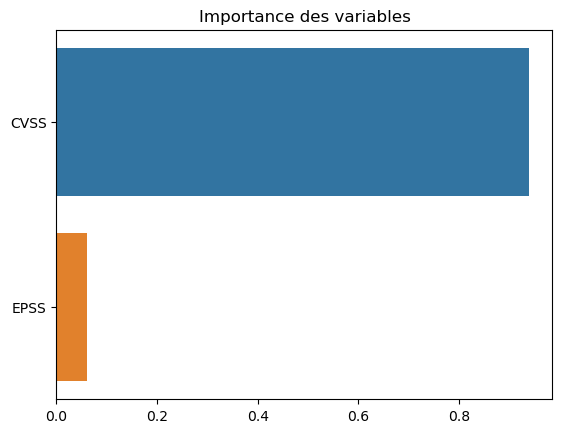

In [6]:
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Importance des variables")
plt.show()

Random Forest pour prédire EPSS

In [7]:
df_reg = df.copy()

df_reg = df_reg.dropna(subset=["EPSS", "CVSS"])

df_reg["EPSS"] = pd.to_numeric(df_reg["EPSS"], errors="coerce")
df_reg["CVSS"] = pd.to_numeric(df_reg["CVSS"], errors="coerce")
#df_reg["Longueur description"] = pd.to_numeric(df_reg["Longueur description"], errors="coerce")

for col in ["Base Severity", "CWE"]:
    df_reg[col] = LabelEncoder().fit_transform(df_reg[col].astype(str))


features = ["CVSS", "Base Severity", "CWE"]
X = df_reg[features]
y = df_reg["EPSS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))

MAE : 0.030204193796474064
MSE : 0.008913845436300949
RMSE: 0.0944131634694069
R²  : 0.33672000876961894


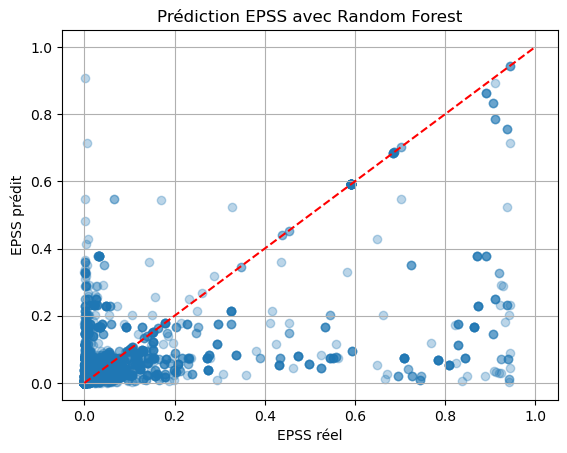

In [10]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("EPSS réel")
plt.ylabel("EPSS prédit")
plt.title("Prédiction EPSS avec Random Forest")
plt.plot([0, 1], [0, 1], 'r--')
plt.grid()
plt.show()

XGBoost Regressor pour prédire EPSS

In [11]:

for col in ["Base Severity", "CWE"]:
    df[col] = df[col].astype(str)  
    df[col] = LabelEncoder().fit_transform(df[col])
# Même préparation que pour RandomForest
features = ["CVSS", "Base Severity", "CWE"]
X = df[features]
y = df["EPSS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))

MAE : 0.034065270013626976
RMSE: 0.09650867465578564
R²  : 0.30695010795994637


Random Forest est mieux que XGBoost

Random Forest pour prédire le nom de l'éditeur

Random Forest sans SMOTE (échantillonage)

In [12]:
df_clf = df.dropna(subset=["Éditeur", "CVSS", "EPSS", "Base Severity"])
df_clf = df_clf[df_clf["Éditeur"].map(df_clf["Éditeur"].value_counts()) > 50]  # éditeurs fréquents

le_editeur = LabelEncoder()
df_clf["Éditeur_encoded"] = le_editeur.fit_transform(df_clf["Éditeur"])

le_severity = LabelEncoder()
df_clf["Base Severity"] = le_severity.fit_transform(df_clf["Base Severity"])

le_cwe = LabelEncoder()
df_clf["CWE"] = le_cwe.fit_transform(df_clf["CWE"].astype(str))


X = df_clf[["CVSS", "EPSS", "Base Severity", "CWE"]]
y = df_clf["Éditeur_encoded"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

                                  precision    recall  f1-score   support

                             AMD       0.97      1.00      0.99        70
                           Adobe       0.69      0.39      0.50        51
      Apache Software Foundation       0.76      0.88      0.82        33
                           Apple       0.78      0.84      0.81       239
                         CODESYS       0.99      0.98      0.99       123
                           Cisco       0.78      0.62      0.69        45
                              F5       0.76      0.46      0.58        28
                        Fortinet       0.76      0.66      0.71        80
                          GitLab       0.37      0.20      0.26        56
             Go standard library       0.88      0.88      0.88        16
                          Google       0.90      0.82      0.86       193
Hewlett Packard Enterprise (HPE)       0.93      0.70      0.80        40
                             IBM     

Random Forest avec SMOTE

In [13]:

from imblearn.over_sampling import SMOTE

df_clf = df.dropna(subset=["Éditeur", "CVSS", "EPSS", "Base Severity"])
df_clf = df_clf[df_clf["Éditeur"].map(df_clf["Éditeur"].value_counts()) > 50]  

le_editeur = LabelEncoder()
df_clf["Éditeur_encoded"] = le_editeur.fit_transform(df_clf["Éditeur"])

le_severity = LabelEncoder()
df_clf["Base Severity"] = le_severity.fit_transform(df_clf["Base Severity"])

le_cwe = LabelEncoder()
df_clf["CWE"] = le_cwe.fit_transform(df_clf["CWE"].astype(str))


X = df_clf[["CVSS", "EPSS", "Base Severity", "CWE"]]
y = df_clf["Éditeur_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

                                  precision    recall  f1-score   support

                             AMD       0.99      1.00      0.99        70
                           Adobe       0.57      0.53      0.55        51
      Apache Software Foundation       0.78      0.88      0.83        33
                           Apple       0.86      0.84      0.85       239
                         CODESYS       0.99      0.98      0.99       123
                           Cisco       0.53      0.62      0.57        45
                              F5       0.82      0.50      0.62        28
                        Fortinet       0.64      0.68      0.66        80
                          GitLab       0.38      0.30      0.34        56
             Go standard library       0.70      0.88      0.78        16
                          Google       0.80      0.85      0.82       193
Hewlett Packard Enterprise (HPE)       0.76      0.78      0.77        40
                             IBM     

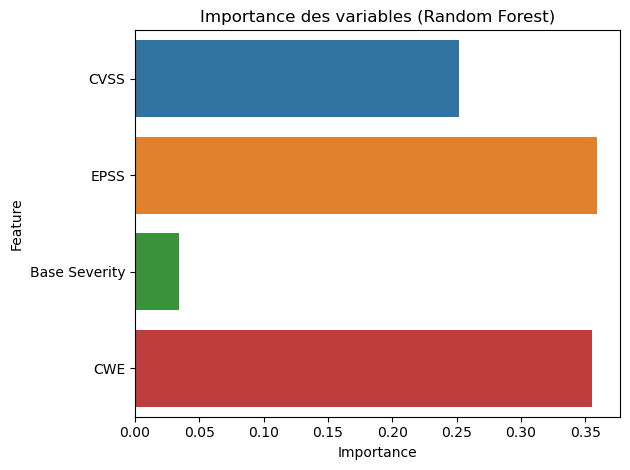

In [14]:
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Importance des variables (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

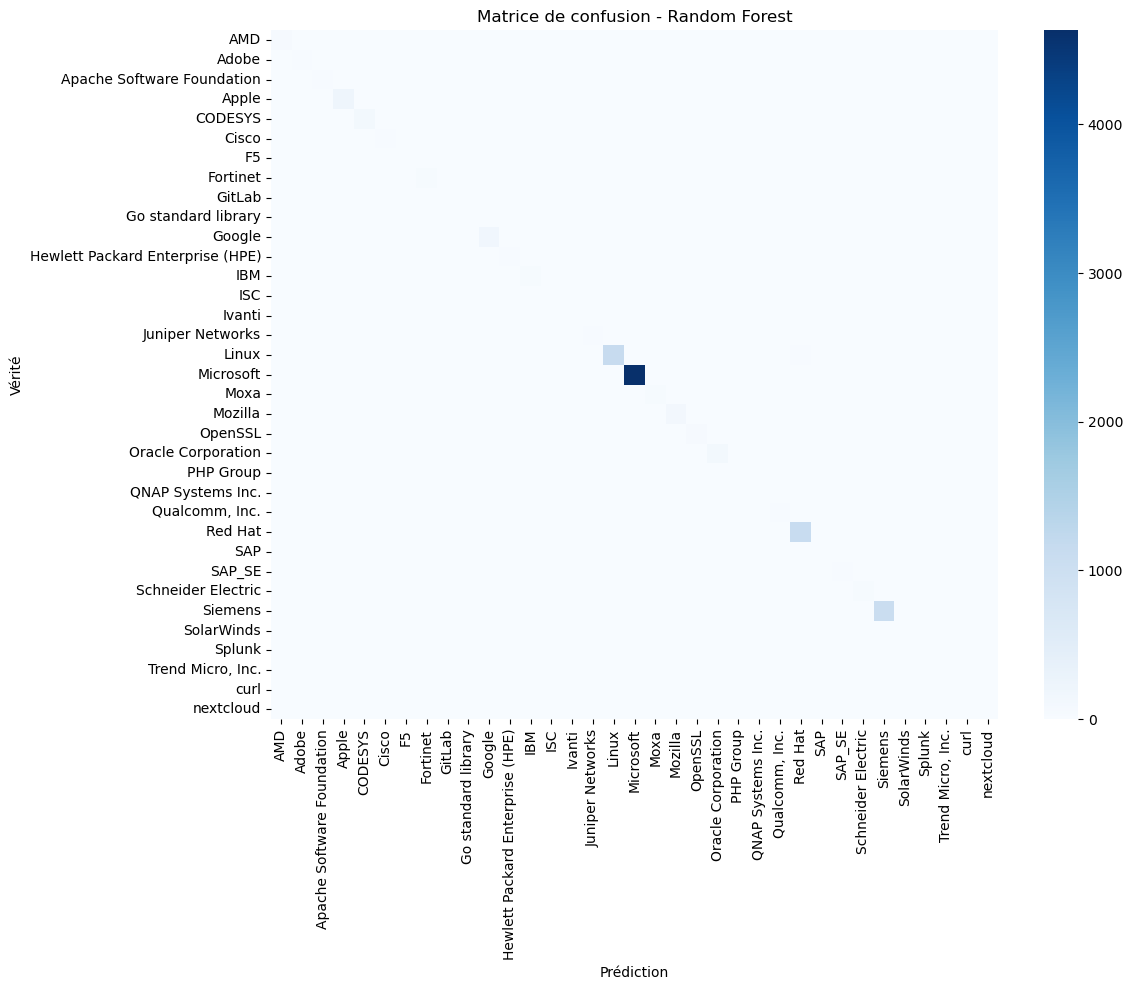

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_, 
            annot=False, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


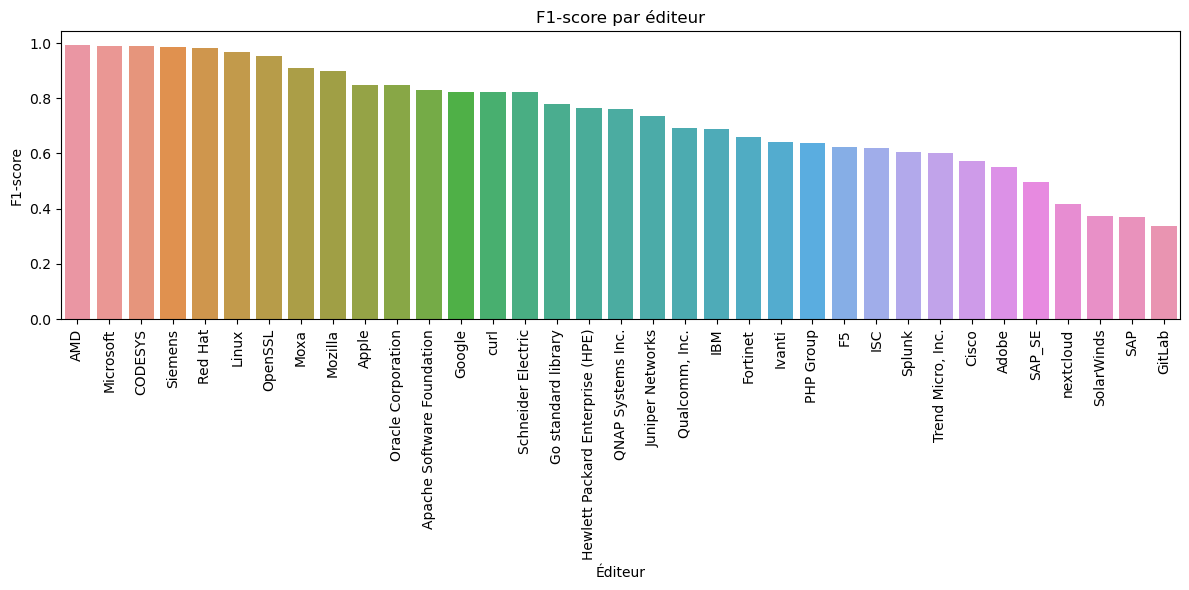

In [17]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_scores = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        f1_scores[label] = report_dict[str(i)]["f1-score"]
    except KeyError:
        f1_scores[label] = 0


f1_scores_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores_sorted.keys()), y=list(f1_scores_sorted.values()))
plt.xticks(rotation=90)
plt.title("F1-score par éditeur")
plt.ylabel("F1-score")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


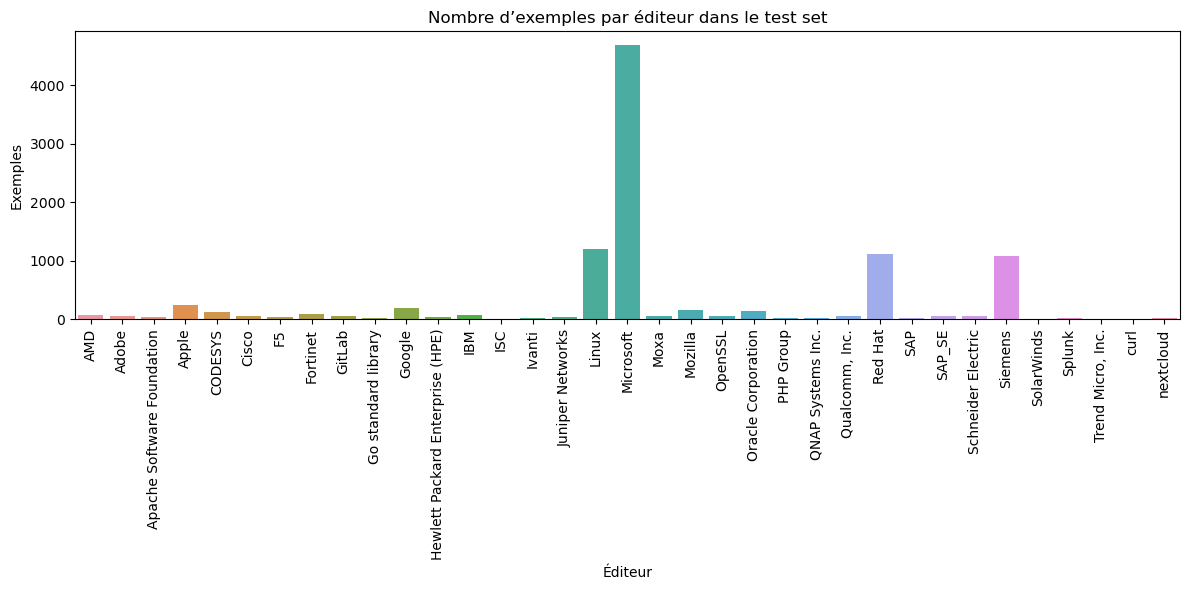

In [20]:
support = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        support[label] = report_dict[str(i)]["support"]
    except KeyError:
        support[label] = 0  


plt.figure(figsize=(12, 6))
sns.barplot(x=list(support.keys()), y=list(support.values()))
plt.xticks(rotation=90)
plt.title("Nombre d’exemples par éditeur dans le test set")
plt.ylabel("Exemples")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()